## 1D 컨브넷 구현

- 케라스에서 1D 컨브넷은 `Conv1D` 층을 사용하여 구현합니다. 
- `Conv1D`는 `Conv2D`와 인터페이스가 비슷합니다. `(samples, time, features)` 크기의 3D 텐서를 입력받고 비슷한 형태의 3D 텐서를 반환합니다. 
- 합성곱 윈도우는 시간 축의 1D 윈도우입니다. 즉, 입력 텐서의 두 번째 축입니다.

- 간단한 두 개 층으로 된 1D 컨브넷을 만들어 익숙한 IMDB 감성 분류 문제에 적용


In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000
max_len = 500

(x_train, y_train), (x_test,y_test) = imdb.load_data(num_words = max_features)
print(len(x_train), len(x_test))

x_train = sequence.pad_sequences(x_train,maxlen = max_len)
x_test = sequence.pad_sequences(x_test,maxlen = max_len)
print(x_train.shape, x_test.shape)

17473536/17464789 [==============================] - 0s 0us/step
25000 25000
(25000, 500) (25000, 500)


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features,128,input_length=max_len))
model.add(layers.Conv1D(32,7,activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32,7,activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 3

In [4]:
model.compile(optimizer = RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train,y_train,
                    epochs=10,
                    batch_size = 128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 2s 11ms/step - loss: 0.6834 - acc: 0.5842 - val_loss: 0.6758 - val_acc: 0.6124
Epoch 2/10
157/157 [==============================] - 2s 10ms/step - loss: 0.6483 - acc: 0.7216 - val_loss: 0.6432 - val_acc: 0.7106
Epoch 3/10
157/157 [==============================] - 2s 10ms/step - loss: 0.5879 - acc: 0.7912 - val_loss: 0.5648 - val_acc: 0.7662
Epoch 4/10
157/157 [==============================] - 2s 10ms/step - loss: 0.4748 - acc: 0.8234 - val_loss: 0.4483 - val_acc: 0.8204
Epoch 5/10
157/157 [==============================] - 1s 9ms/step - loss: 0.3759 - acc: 0.8582 - val_loss: 0.4094 - val_acc: 0.8438
Epoch 6/10
157/157 [==============================] - 1s 9ms/step - loss: 0.3179 - acc: 0.8853 - val_loss: 0.3937 - val_acc: 0.8600
Epoch 7/10
157/157 [==============================] - 2s 10ms/step - loss: 0.2823 - acc: 0.9008 - val_loss: 0.3922 - val_acc: 0.8684
Epoch 8/10
157/157 [==============================] - 2s 10ms/step - lo

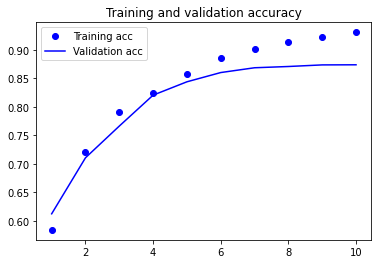

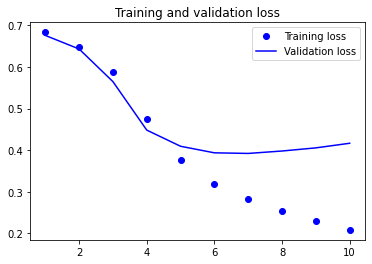

In [5]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

검증 정확도는 LSTM보다는 낮지만 CPU, GPU 에서 더 빠르게 실행된다. 단어 수준의 감성 분류 작업에 순환 네트워크를 대신하여 빠르고 경제적인 1D 컨브넷을 사용할 수 있다.

In [7]:
import os
import numpy as np

data_dir = '/content/drive/MyDrive/cakd5/m9_딥러닝알고리즘구현/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size




In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32,5,activation='relu',input_shape=(None,float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          5152      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, None, 32)          5152      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)              

In [9]:
model.compile(optimizer = RMSprop(),
              loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 12s 22ms/step - loss: 0.4235 - val_loss: 0.4324
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3644 - val_loss: 0.4368
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3376 - val_loss: 0.4377
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3221 - val_loss: 0.4517
Epoch 5/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3107 - val_loss: 0.4752
Epoch 6/20
500/500 [==============================] - 12s 25ms/step - loss: 0.3005 - val_loss: 0.4538
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2930 - val_loss: 0.4501
Epoch 8/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2871 - val_loss: 0.4618
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2787 - val_loss: 0.4689
Epoch 10/20
500/500 [==============================] - 11s 22ms/step - loss: 0.272

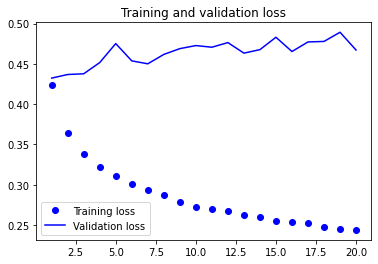

In [12]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [13]:
lookback = 1440
step = 3
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32,5,activation='relu',input_shape=(None,float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.GRU(32,dropout=0.1,recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
__________________________________________________

In [15]:
model.compile(optimizer = RMSprop(),
              loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 310s 615ms/step - loss: 0.3331 - val_loss: 0.3145
Epoch 2/20
500/500 [==============================] - 305s 611ms/step - loss: 0.2992 - val_loss: 0.2788
Epoch 3/20
500/500 [==============================] - 303s 607ms/step - loss: 0.2839 - val_loss: 0.3028
Epoch 4/20
500/500 [==============================] - 302s 605ms/step - loss: 0.2734 - val_loss: 0.2724
Epoch 5/20
500/500 [==============================] - 301s 603ms/step - loss: 0.2649 - val_loss: 0.2800
Epoch 6/20
500/500 [==============================] - 299s 599ms/step - loss: 0.2576 - val_loss: 0.2799
Epoch 7/20
500/500 [==============================] - 302s 604ms/step - loss: 0.2507 - val_loss: 0.2844
Epoch 8/20
500/500 [==============================] - 300s 600ms/step - loss: 0.2440 - val_loss: 0.2807
Epoch 9/20
500/500 [==============================] - 302s 605ms/step - loss: 0.2381 - val_loss: 0.2944
Epoch 10/20
500/500 [==============================] - 299s 598m

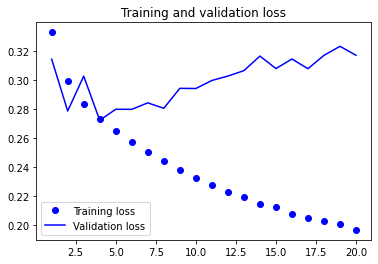

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()